# Parallel External Source

In this tutorial we will show you how to enable parallel mode in `external_source` operator, allowing the `source` to be executed concurrently by Python worker processes. Doing so can reduce the execution time of each iteration by allowing source to run in the background, unblocking the main Python thread. Not every usage of `external_source` can be parallelized straight away - the `source` argument is subject to a set of restrictions and there is additional configuration required.

## Accepted `source`
DALI parallel External Source places following requirements on the `source` parameter that can be used:

1. `source` must be a callable: function or object. 
2. `source` callback must accept one argument: nvidia.dali.types.SampleInfo - indicating the index of requested sample.
3. Currently only per-sample (`batch=False`) mode is supported.
4. Data returned by the callback must be a CPU array (or tuple/list of them).

Following paragraphs will explain the reasoning behind those requirements and show examples of using the parallel External Source.
 

## Principle Of Operation

Before every iteration, DALI External Source operator queries its `source` parameter for new data to pass it further for processing in the pipeline. The time necessary to obtain data from `source` by calling it (when the `source` is callable) or calling `next(source)` (in case of iterabe) can be significant and it can impact the time to process an iteration - especially as it's a blocking operation in the main Python thread.

Setting `parallel=True` for an `external_source` node indicates to the pipeline to run the `source` in Python worker processes started by DALI. The worker processes are bound to pipeline and shared by all parallel external sources in that pipeline.
Each of those workers keeps a **copy** of the `source` callback. The worksers are separate processes, so keep in mind that they do not share any global state other than what was specified before starting the workers.

Each process can request a particular sample from its copy of `source` callback by invoking it with [SampleInfo](https://docs.nvidia.com/deeplearning/dali/user-guide/docs/data_types.html#sampleinfo) object containing requested sample's index.   
DALI pipeline sends to each of the worker processes which samples will be required ahead of time and collects the data back for use in current iteration.
Iterable objects do not allow to select a particular sample to be returned and thus are not supported in the parallel mode.

Because we want to speed up the computation of the whole input batch for given iteration, parallel mode supports only per-sample inputs - allowing to compute samples in parallel. We must either set `batch=False` or leave it unspecified, as it's implied by `parallel=True`.


## Example Pipeline and `source`

Let's take the simplified example from [ExternalSource Operator tutorial](external_input.ipynb). Although it is using an iterable, which is prohibited, we will convert it to a callable object as a next step.

In [1]:
import numpy as np
from nvidia.dali import pipeline_def
import nvidia.dali.fn as fn

batch_size = 4

class ExternalInputIterator:
    def __init__(self, batch_size):
        self.images_dir = "../../data/images/"
        self.batch_size = batch_size
        with open(self.images_dir + "file_list.txt", 'r') as f:
            file_label = [line.rstrip().split(' ') for line in f if line != '']
            self.files, self.labels = zip(*file_label)

    def __iter__(self):
        self.i = 0
        # Only full batches
        self.n = (len(self.files) // self.batch_size) * self.batch_size 
        return self

    def __next__(self):
        if self.i >= self.n:
            raise StopIteration()
        encoded_imgs, labels = [], []
        for _ in range(self.batch_size):
            jpeg_filename = self.files[self.i]
            label = self.labels[self.i]
            with open(self.images_dir + jpeg_filename, 'rb') as f:
                encoded_imgs.append(np.frombuffer(f.read(), dtype=np.uint8))
            labels.append(np.int32([label]))
            self.i += 1
        return encoded_imgs, labels

### Adjusting To Callable Object

We need to make two adjustments here:

1. Convert it to per-sample mode
2. Instead of returning the data sequentially in `__next__`, implement `__call__` that is able to return a specific sample.

We can keep the `__init__` that initializes the object. We no longer need `__iter__`.

Now, instead of the iterator keeping track of which sample (or batch) to return next, that information comes from DALI via the `sample_info` parameter - the member variables describing the index of sample are specified in the [SampleInfo type documentation](https://docs.nvidia.com/deeplearning/dali/user-guide/docs/data_types.html#sampleinfo).

#### Epochs

Additionally, we precompute the numbers of full batches in the epoch. This way we will drop last, partial batch - alternatively, we could support padding the batch, but it is out of the scope of this tutorial. External Source in parallel mode does not support partial batches. 

**It is recommended that all copies of the `source` callback raise the `StopIteration` for the same `iteration` (and all sample indices for batch requested in that iteration).** 

This is why we computed the number of full batches and raise the `StopIteration` for any greater or equal iteration index.

After `StopIteration` was raised, we can call `pipeline.reset()` to reset the SampleInfo - DALI will start counting from the sample index and iteration index 0.

In [2]:
class ExternalInputCallable:
    def __init__(self, batch_size):
        self.images_dir = "../../data/images/"
        self.batch_size = batch_size
        with open(self.images_dir + "file_list.txt", 'r') as f:
            file_label = [line.rstrip().split(' ') for line in f if line != '']
            self.files, self.labels = zip(*file_label)
        self.full_iterations = len(self.files) // batch_size

    def __call__(self, sample_info): 
        sample_idx = sample_info.idx_in_epoch
        if sample_info.iteration >= self.full_iterations:
            # Indicate end of the epoch
            raise StopIteration()
        jpeg_filename = self.files[sample_idx]
        label = np.int32([self.labels[sample_idx]])
        with open(self.images_dir + jpeg_filename, 'rb') as f:
            encoded_img = np.frombuffer(f.read(), dtype=np.uint8)
        return encoded_img, label

The callable object is used only as an example. If you wish, you can use stateless function like:

In [3]:
def my_callback(sample_info):
    return np.full((5, 5), sample_info.idx_in_epoch)

#### Shuffling

If you wish to shuffle your data, remember that you are dealing with multiple copies of the `source` callback. Every copy should shuffle the data in the same way, otherwise you risk mixing your dataset and returning the same sample multiple times in the same batch.

### Pipeline Definition

Now we can define two pipelines - **for now not using parallel mode** - to see that both methods give us the same results. 
Take a note that we set `batch=False` in the second example.

In [4]:
@pipeline_def(batch_size=batch_size, num_threads=2, device_id=0)
def iterable_pipeline():
    jpegs, labels = fn.external_source(source=ExternalInputIterator(batch_size), num_outputs=2)
    decode = fn.decoders.image(jpegs, device="mixed")
    return decode, labels
    

@pipeline_def(batch_size=batch_size, num_threads=2, device_id=0)
def callable_pipeline():
    jpegs, labels = fn.external_source(source=ExternalInputCallable(batch_size), num_outputs=2, batch=False)
    decode = fn.decoders.image(jpegs, device="mixed")
    return decode, labels

### Testing The Pipelines

Let's introduce some helper code to display the results.

In [5]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import math

def display(outputs, count, columns=2, captions=None, cpu=False):
    rows = int(math.ceil(len(outputs) / columns))
    fig = plt.figure()
    fig.set_size_inches(16, 6 * rows)
    gs = gridspec.GridSpec(rows, columns)
    row = 0
    col = 0
    for i in range(count):
        plt.subplot(gs[i])
        plt.axis("off")
        if captions is not None:
            plt.title(captions[i])
        plt.imshow(outputs.at(i) if cpu else outputs.as_cpu().at(i))



And now we can build and run the pipelines.

In [6]:
iter_pipe = iterable_pipeline()
iter_pipe.build()
iter_out = iter_pipe.run()

call_pipe = callable_pipeline()
call_pipe.build()
call_out = call_pipe.run()

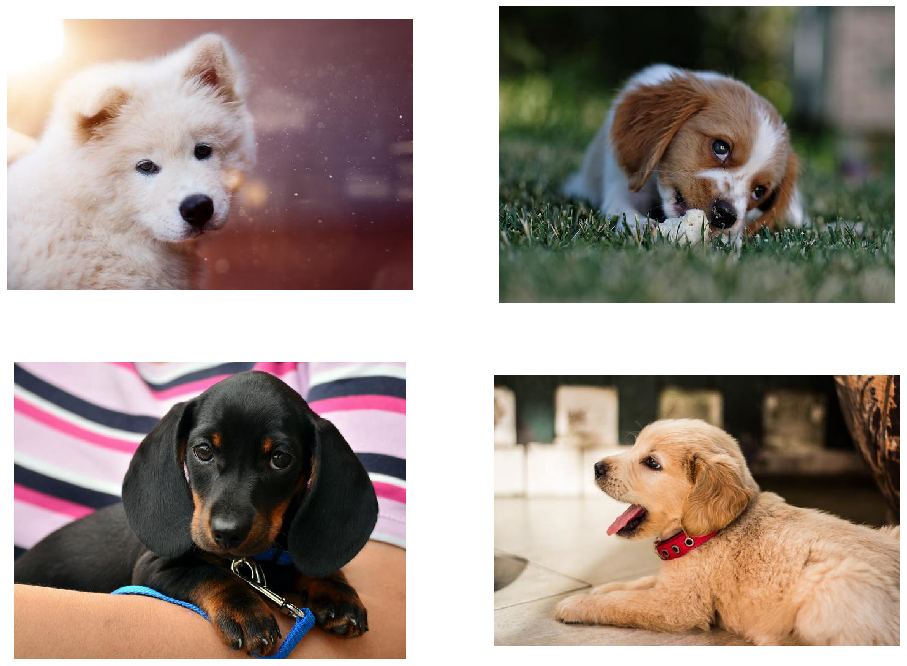

In [7]:
display(iter_out[0], batch_size)

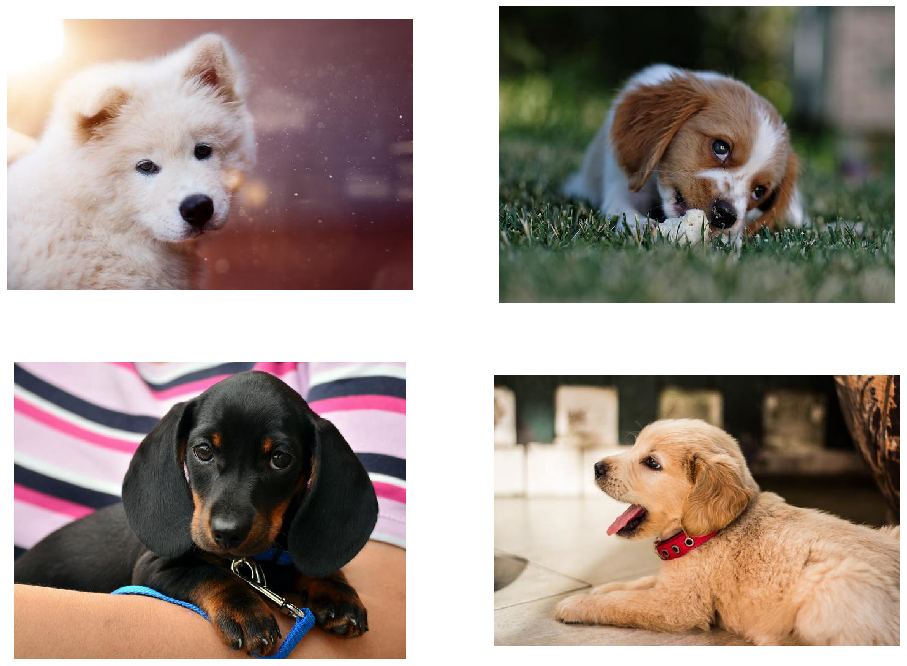

In [8]:
display(call_out[0], batch_size)

## Going Parallel
Now that we have a pipeline with a callable `source` that is compatible with the parallel `external_source` requirements, we can adjust our pipeline. We need to modify our `callable_pipeline`, by setting `parallel=True` for the `external_source` operator.

There are two additional parameters that we can set for the pipeline to control the behaviour of Python worker processes:

1. `py_num_workers` - sets the number of the workers - by default it's 1, but we will use more, to achieve better parallelism when calculating batches.
2. `py_start_method` - controls how the worker processes are started.


### Starting Python Workers

Parallel External Source uses [Python multiprocessing library](https://docs.python.org/3/library/multiprocessing.html) to control the worker processes. Two methods of starting the workers are supported in DALI: `'fork'` and `'spawn'`. Details on the start methods are [here](https://docs.python.org/3/library/multiprocessing.html#contexts-and-start-methods). DALI does not support `'forkserver'` method, as the startup of workers is done once, at the beginning of the processing, and using this method would not yield any additonal benefits over the two other methods. 

In general, the `source` callback should adhere to the [multiprocessing programming guidelines](https://docs.python.org/3/library/multiprocessing.html#programming-guidelines) to avoid unwanted behaviour or errors.

#### Fork

The first one, `'fork'`, creates a fork of the current Python interpreter, meaning that the new process is identical and all the objects existing in the original one are avialable in the new one as well. There is a limitaion however, that the process that acquired CUDA context (usually done by any interaction with CUDA code like creating a framework CUDA tensors, calling `build()` on DALI pipeline, etc) cannot be forked. 

To alleviate this problem, there is a Pipeline method called `start_py_workers()` which can be used to start the worker processes before we need to interact with CUDA. 

The typical approach would be to do the following before interacting with CUDA:

1. Define all DALI pipelines (do not use build())
2. Collect all DALI pipeline objects.
3. Run `start_py_workers()` on every pipeline object.

After those steps, the pipelines can be built and CUDA can be accessed. 

In this tutorial we have already used DALI to run the operations on GPU, so the current Jupyter Notebook Kernel instance already acquired a CUDA context.

The example of using `start_py_workers()` can be seen in separate tutorial [Parallel External Source - Fork](parallel_external_source_fork.ipynb), where we wait with acquiring a CUDA context.

#### Spawn
The `'spawn'` method starts a new Python interpreter process and shares the necessery state by serializing and deserializing it. Thus, the `source` callable needs to be [picklable](https://docs.python.org/3/library/pickle.html) to work with this method. 

When `'spawn'` is used, make sure that the main module can be safely imported by guarding the entry point with `if __name__ == '__main__'` as described in [multiprocessing programming guidelines](https://docs.python.org/3/library/multiprocessing.html#programming-guidelines).

`'spawn'` does not interfere with CUDA context, and there is no need to call the `start_py_workers()` separately - it's done inside the `build()` step.
As this tutorial notebook has already acquired a CUDA context, we will use this method to run our pipeline.

Unfortunatelly, there is again a limitation with Jupyter Notebook - the callable must come from the Python module that is visible to the new process. As a workaround, we will write the definition of `ExternalInputCallable` to a helper file and import it again, so it will come from a named module and be easily picklable.

Such workarounds are not required in regular Python code.

In [9]:
external_input_callable_def = """
import numpy as np

class ExternalInputCallable:
    def __init__(self, batch_size):
        self.images_dir = "../../data/images/"
        self.batch_size = batch_size
        with open(self.images_dir + "file_list.txt", 'r') as f:
            file_label = [line.rstrip().split(' ') for line in f if line is not '']
            self.files, self.labels = zip(*file_label)
        self.n = len(self.files)

    def __call__(self, sample_info): 
        jpeg_filename = self.files[sample_info.idx_in_epoch]
        label = np.int32([self.labels[sample_info.idx_in_epoch]])
        with open(self.images_dir + jpeg_filename, 'rb') as f:
            encoded_img = np.frombuffer(f.read(), dtype=np.uint8)
        return encoded_img, label
"""


with open("external_input_tmp_module.py", 'w') as f:
    f.write(external_input_callable_def)
    
import external_input_tmp_module

## Running The Pipeline With Python Workers

Now, we can adjust the pipeline definition to run in parallel by adding `parallel=True` to `external_source` and passing the parameters `py_num_workers` and `py_start_method` to the pipeline. Remember to also use the newly imported `source` definition.

In [10]:
@pipeline_def(batch_size=batch_size, num_threads=2, device_id=0, py_num_workers=4, py_start_method='spawn')
def parallel_pipeline():
    jpegs, labels = fn.external_source(source=external_input_tmp_module.ExternalInputCallable(batch_size),
                                       num_outputs=2, batch=False,
                                       parallel=True)
    decode = fn.decoders.image(jpegs, device="mixed")
    return decode, labels

In [11]:
if __name__ == '__main__':
    parallel_pipe = parallel_pipeline()
    parallel_pipe.build()

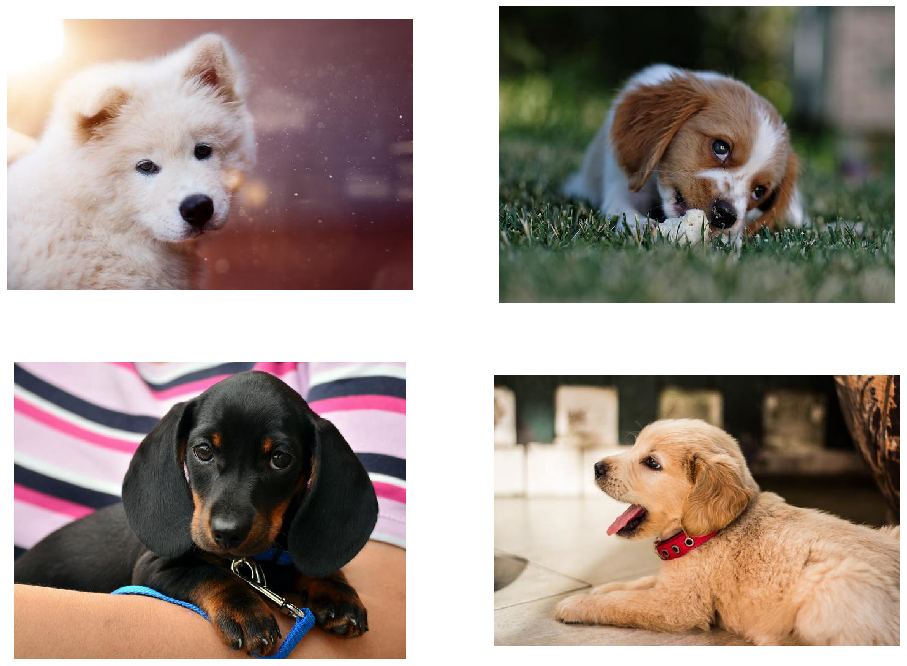

In [12]:
if __name__ == '__main__':
    parallel_out = parallel_pipe.run()
    display(parallel_out[0], batch_size)